### sys.path 보정

In [12]:
import os, sys
import keras
PROJECT_ROOT = os.path.abspath("..") 
print("PROJECT_ROOT:", PROJECT_ROOT)
print("Exists src?:", os.path.isdir(os.path.join(PROJECT_ROOT, "src")))
print("List root:", os.listdir(PROJECT_ROOT)[:20])

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

%load_ext autoreload
%autoreload 2


PROJECT_ROOT: /home/mun03/work/projects/cv-lab1/malaria-detection/project
Exists src?: True
List root: ['configs', 'notebook', 'src', '_olds']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports & Config 로드

In [13]:
from src.utils.config import load_config

cfg = load_config("../configs/exp001.yaml")
cfg

Config(run=RunCfg(name='exp001', out_dir='runs', seed=42), data=DataCfg(dataset='tfds:malaria', img_size=128, batch_size=32, val_split=0.2, test_split=0.0, shuffle_buffer=10000, num_parallel_calls='AUTOTUNE'), augment=AugmentCfg(enabled=True, random_flip=True, random_brightness=0.1, random_contrast=0.1), model=ModelCfg(name='simple_cnn', num_classes=2, dropout=0.2, base_trainable=True), train=TrainCfg(epochs=1, optimizer='adam', learning_rate=0.001, loss='sparse_categorical_crossentropy', monitor='val_auc', monitor_mode='max', early_stop_patience=5), report=ReportCfg(load_tb_after_fit=True, is_need_save_draw_auc=True, tensorboard_port=6006))

### Seed 고정 + run_dir 생성

In [14]:
import platform
import tensorflow as tf
from src.utils.seed import set_global_seed
from src.utils.io import make_run_dir, copy_config, save_metadata, try_git_commit_hash

set_global_seed(cfg.run.seed)
run_dir = make_run_dir(cfg.run.out_dir, cfg.run.name)
copy_config("../configs/exp001.yaml", run_dir)

save_metadata(
    run_dir,
    {
        "run_dir": run_dir,
        "git_commit": try_git_commit_hash(),
        "python": platform.python_version(),
        "tensorflow": tf.__version__,
        "seed": cfg.run.seed,
        "monitor": cfg.train.monitor,
    },
)
run_dir

'runs/exp001_2026-01-18_061829'

### Dataset 생성 (pipeline 재사용)

In [15]:
from src.data.pipeline import build_datasets

train_ds, val_ds, test_ds, num_classes = build_datasets(cfg)
num_classes

2

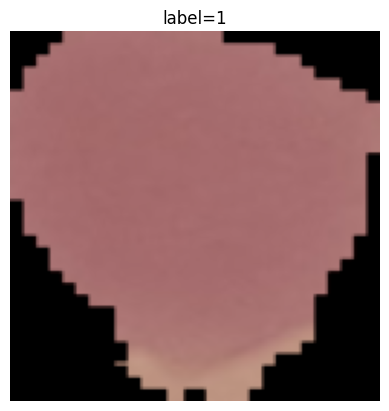

In [16]:
import matplotlib.pyplot as plt

x, y = next(iter(train_ds))
plt.figure()
plt.imshow(x[0].numpy())
plt.title(f"label={int(y[0])}")
plt.axis("off")
plt.show()

### Model 생성 + compile

In [17]:
from src.models.model_factory import build_model

model = build_model(cfg, num_classes=num_classes)
model.summary()

Model: "simple_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prob (Dense)                    │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,273 (368.25 KB)

 Trainable params: 93,825 (366.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
from src.models.model_factory import build_optimizer

model.compile(
    optimizer=build_optimizer(cfg.train.optimizer, cfg.train.learning_rate),
    loss=cfg.train.loss,
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.AUC(name="auc"),
    ],
)

### Callbacks 설정 + fit

In [19]:
ckpt_dir = os.path.join(run_dir, "checkpoints")
tb_dir = os.path.join(run_dir, "logs")
best_sm = os.path.join(run_dir, "best_savedmodel.h5")

callbacks = [
    keras.callbacks.TensorBoard(log_dir=tb_dir),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, "last.weights.h5"),
        save_weights_only=True,
        save_best_only=False,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, "best.weights.h5"),
        save_weights_only=True,
        monitor=cfg.train.monitor,
        mode=cfg.train.monitor_mode,
        save_best_only=True,
    ),
    keras.callbacks.EarlyStopping(
        monitor=cfg.train.monitor,
        mode=cfg.train.monitor_mode,
        patience=cfg.train.early_stop_patience,
        restore_best_weights=True,
    ),
]

In [20]:
from src.utils.report import export_model_graph


x0, y0 = next(iter(train_ds))  # 배치 1개
export_model_graph(tb_dir, model, (x0, y0), step=1)  # step은 0 말고 1 이상 추천

In [ ]:
history = model.fit(
    train_ds, validation_data=val_ds, epochs=cfg.train.epochs, callbacks=callbacks
)
keras.saving.save_model(model, best_sm)
best_sm

358/689 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5026 - auc: 0.4945 - loss: nan

### tensorboard 열기

In [ ]:
from src.utils.report import start_tensorboard, open_in_windows_browser

# config.report.load_tb_after_fit가 True일 때만 실행
if not cfg.report.load_tb_after_fit:
    exit()

# 포트는 cfg에서 가져옴
config_report_port = cfg.report.tensorboard_port

# model.fit() 끝난 뒤:
url = start_tensorboard(tb_dir, port=config_report_port)  # tb_dir = run_dir/logs
print("TensorBoard:", url)

# VSCode가 포트 포워딩 해주면 Windows에서는 보통 localhost로 접근
open_in_windows_browser(url)

: 

### 학습 시각화

In [ ]:
import pandas as pd

hist = pd.DataFrame(history.history)
hist.tail()

: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(hist["loss"], label="loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.legend()
plt.show()

: 

### Eval / Confusion matrix

In [ ]:
import numpy as np
from src.utils.report import save_eval_report

ds = test_ds if test_ds is not None else val_ds

y_true, y_pred = [], []
for bx, by in ds:
    p = model.predict(bx, verbose=0)
    y_pred.append(np.argmax(p, axis=1))
    y_true.append(by.numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

save_eval_report(run_dir, y_true, y_pred, num_classes)

: 